In [1]:
import os.path
from collections import Counter

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import seaborn

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
SIMULATIONS = 1000 * 1000


ec_votes = {
    "WA": 12,
    "OR": 7,
    "CA": 55,
    "NV": 6,
    "MT": 3,
    "ID": 4,
    "UT": 6,
    "AZ": 11,
    "CO": 9,
    "NM": 5,
    "WY": 3,
    "ND": 3,
    "SD": 3,
    "NE": 2, "NE1": 1, "NE2": 1, "NE3": 1,
    "KS": 6,
    "OK": 7,
    "TX": 38,
    "LA": 8,
    "AR": 6,
    "MO": 10,
    "IA": 6,
    "MN": 10,
    "WI": 10,
    "IL": 20,
    "MI": 16,
    "IN": 11,
    "TN": 11,
    "KY": 8,
    "MS": 6,
    "AL": 9,
    "GA": 16,
    "FL": 29,
    "HI": 4,
    "AK": 3,
    "DE": 3,
    "DC": 3,
    "VT": 3,
    "ME": 2, "ME1": 1, "ME2": 1,
    "NH": 4,
    "RI": 4,
    "WV": 5,
    "CT": 7,
    "SC": 9,
    "MD": 10,
    "MA": 11,
    "VA": 13,
    "NJ": 14,
    "NC": 15,
    "OH": 18,
    "PA": 20,
    "NY": 29,
}

# Pixels to the midpoint
fifty_percent = 206.

# Number of stdevs covered by symmetric 80%
eighty_percent = 1.2816

In [3]:
def prob_of_winning(fifty_percent, mean, stdev):
    zscore = (fifty_percent - mean) / stdev
    return st.norm.cdf(zscore)


def get_dists(filename):
    with open(filename) as handle:
        data = handle.read()
    print("data: {0}".format(len(data)))
    soup = BeautifulSoup(data, "lxml")

    state_class = {"class": "state"}
    forecast_class = {"class": "forecast"}
    rect_class = {"class": "ci D"}

    states = soup.find_all("g", state_class)
    print("States: {0}".format(len(states)))
    ecs = [
        ec_name["data-state"]
        for state in states
        for ec_name in state.find_all("rect", {"class": "click"})
    ]
    print("ECS: {0}".format(len(ecs)))

    forecasts = [
        forecast
        for state in states
        for forecast in state.find_all("g", forecast_class)
    ]
    print("forecasts: {0}".format(len(forecasts)))
    
    dists = [
        {
            "name": ec,
            "width": float(rect["width"]),
            "left": float(rect["x"]),
            # "center": float(circle["cx"])
        }
        for forecast, ec in zip(forecasts, ecs)
        for rect, circle in zip(forecast.find_all("rect", rect_class), forecast.find_all("circle"))
    ]
    print("Districts: {0}".format(len(dists)))

    # Back out the mean and stdev, precalculate linear probability
    for d in dists:
        mean = d["left"] + d["width"] / 2.
        stdev = d["width"] / (2 * eighty_percent)
        prob = prob_of_winning(fifty_percent, mean, stdev)
        d["prob"], d["mean"], d["stdev"] = prob, mean, stdev

    return ecs, dists

Perform draws from each state's distribution of outcomes to simulate possible election outcomes.

In [14]:
def simulate(ecs, dists):
    """
    Do draws from a linear distribution, counting state EC votes
    when the random variable does not exceed the probability of
    winning the state.
    """
    state_probs = np.array([d["prob"] for d in dists])
    prob_iter = (
        np.sum([
            ec_votes[state]
            for state, prob, state_prob in zip(ecs, np.random.random(len(dists)), state_probs)
            if state_prob > prob
        ])
        for _ in range(SIMULATIONS)
    )
    return Counter(prob_iter)


In [15]:
import requests

def get_html_data():
    filename = "2016 Election Forecast _ FiveThirtyEight.htm"
    #url = "http://projects.fivethirtyeight.com/2016-election-forecast/"
    #r = requests.get(url)
    #filename = "a.html"
    #with open(filename, "w") as handle:
    #    handle.write(r.text)
    return filename

In [16]:
print("Pulling forecast data")
filename = get_html_data()

print("Extract distribution data")
ecs, dists = get_dists(filename)

print("Simulate election")
results = simulate(ecs, dists)
print("Done")

Pulling forecast data
Extract distribution data
data: 2681119
States: 56
ECS: 56
forecasts: 56
Districts: 56
Simulate election
Done


In [17]:
print("Number of electoral college districts: {0}".format(len(ecs)))
print("Number of electoral college districts: {0}".format(len(dists)))

Number of electoral college districts: 56
Number of electoral college districts: 56


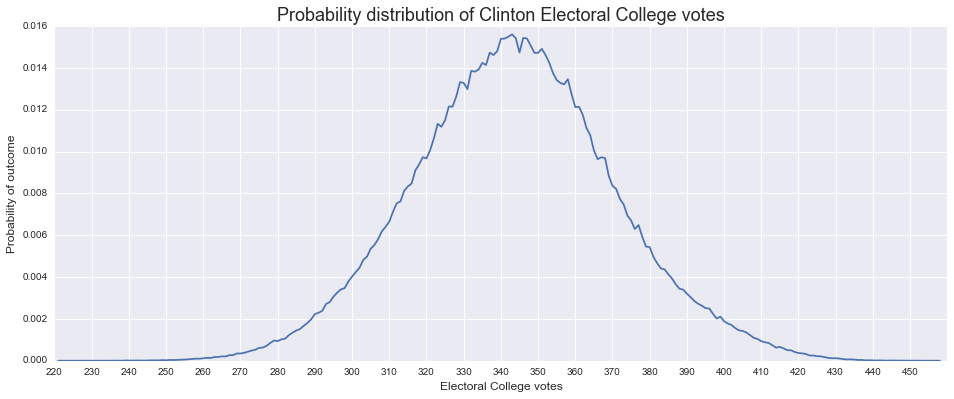

In [23]:
x = list(results.keys())
y = [v / float(SIMULATIONS) for v in results.values()]
min_x, max_x = min(x) - min(x) % 10, max(x) + (10 - max(x) % 10)
plt.figure(figsize=(16, 6))
plt.plot(x, y)
plt.xticks(range(min_x, max_x, 10))
plt.xlim([min_x, max_x])
plt.xlabel("Electoral College votes", fontsize=12)
plt.ylabel("Probability of outcome", fontsize=12)
plt.title("Probability distribution of Clinton Electoral College votes", fontsize=18)
plt.show()

In [9]:
wins = sum(v for k, v in results.items() if k >= 270)
losses = sum(v for k, v in results.items() if k <= 268)

print(float(wins) / SIMULATIONS)
print(float(losses) / SIMULATIONS)

1.0
0.0


In [10]:
from operator import itemgetter

for dist in sorted(dists, key=itemgetter("prob"), reverse=True):
    print("{0}: {1}".format(dist["name"], dist["prob"]))

DC: 1.0
MD: 0.999998933862
CA: 0.999983122592
HI: 0.999865768447
MA: 0.999782597967
NY: 0.999696421222
IL: 0.99728420994
VT: 0.99315189164
CT: 0.992675336125
WA: 0.987533242753
NJ: 0.984222145693
RI: 0.982283932542
OR: 0.974250280411
ME1: 0.973797152855
DE: 0.964726108087
NM: 0.954280613121
VA: 0.935628672916
MI: 0.934137895359
WI: 0.899567710611
MN: 0.896999608565
PA: 0.894104620264
ME: 0.889996034668
CO: 0.874162214406
NH: 0.845368700176
FL: 0.755866285146
NV: 0.747216072775
NC: 0.700486303249
OH: 0.632715115128
IA: 0.627091052463
AZ: 0.535272747277
ME2: 0.51911169825
NE2: 0.50377932541
AK: 0.354289569404
GA: 0.294908130472
MO: 0.233010670281
SD: 0.198833893972
SC: 0.185255515723
NE1: 0.170204544051
TX: 0.153459627364
IN: 0.14913396049
KS: 0.14464779038
MT: 0.132229837501
ND: 0.080420593191
UT: 0.0785452811305
MS: 0.0571954746153
KY: 0.0393755413743
NE: 0.0389571882139
TN: 0.0383598248532
LA: 0.0352885152652
AR: 0.015102495986
ID: 0.00943599681508
WY: 0.00867333515882
WV: 0.006788223